In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [26]:
data='AEP_hourly.csv'
df=pd.read_csv(data)
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [27]:
df = pd.read_csv(data, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [28]:
df.isna().sum()

AEP_MW    0
dtype: int64

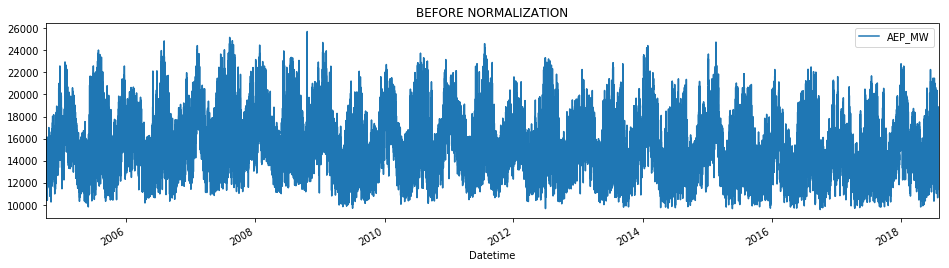

In [29]:
df.plot(figsize=(16,4),legend=True)
plt.title('BEFORE NORMALIZATION')
plt.show()

In [30]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
df_norm = df
df_norm.shape

(121273, 1)

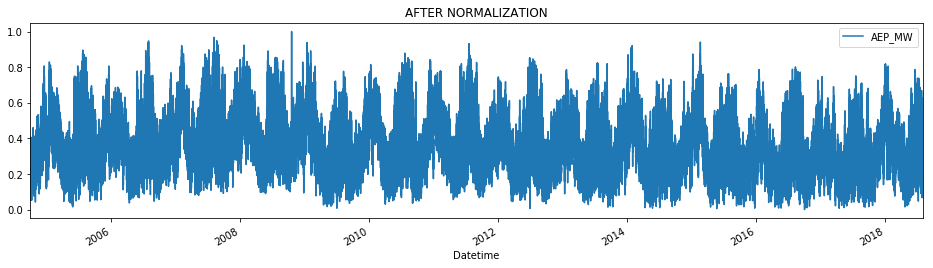

In [31]:
df_norm.plot(figsize=(16,4),legend=True)
plt.title('AFTER NORMALIZATION')
plt.show()

In [32]:
df_norm.shape

(121273, 1)

In [0]:
seq_len = 20
X_ = []
y_ = []
for i in range(seq_len, len(df_norm)):
  X_.append(df_norm.iloc[i-seq_len : i, 0])
  y_.append(df_norm.iloc[i, 0])

X_train = X_[:120000]           
y_train = y_[:120000]
X_test = X_[120000:]             
y_test = y_[120000:]

    
X_train = np.array(X_train)
X_train = np.reshape(X_train, (120000, seq_len, 1))
y_train = np.array(y_train)
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
y_test = np.array(y_test)

In [34]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (120000, 20, 1)
y_train.shape =  (120000,)
X_test.shape =  (1253, 20, 1)
y_test.shape =  (1253,)


In [35]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_9 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total para

In [36]:
rnn_model.compile(optimizer="rmsprop",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=30, batch_size=1000)

Epoch 1/30
120000/120000 [==============================] - 11s 92us/step - loss: 0.1148
Epoch 2/30
120000/120000 [==============================] - 10s 85us/step - loss: 0.0092
Epoch 3/30
120000/120000 [==============================] - 10s 85us/step - loss: 0.0042
Epoch 4/30
120000/120000 [==============================] - 10s 85us/step - loss: 0.0031
Epoch 5/30
120000/120000 [==============================] - 10s 85us/step - loss: 0.0026
Epoch 6/30
120000/120000 [==============================] - 10s 84us/step - loss: 0.0022
Epoch 7/30
120000/120000 [==============================] - 10s 84us/step - loss: 0.0020
Epoch 8/30
120000/120000 [==============================] - 10s 84us/step - loss: 0.0019
Epoch 9/30
120000/120000 [==============================] - 10s 85us/step - loss: 0.0018
Epoch 10/30
120000/120000 [==============================] - 10s 84us/step - loss: 0.0017
Epoch 11/30
120000/120000 [==============================] - 10s 84us/step - loss: 0.0015
Epoch 12/30
120000/

In [37]:
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model =",rnn_score)

R2 Score of RNN model = 0.9495450247441322


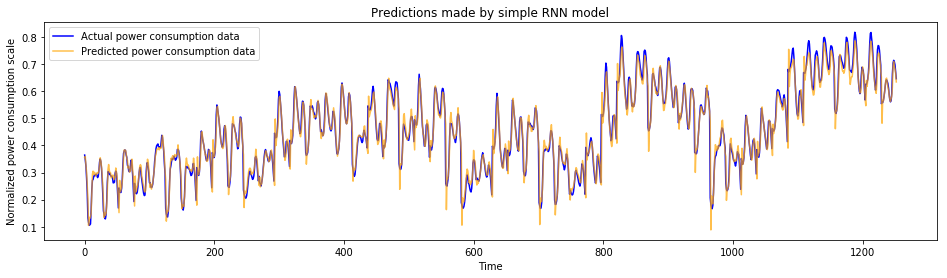

In [38]:
plt.figure(figsize=(16,4))
plt.plot(y_test, color='blue',label='Actual power consumption data')
plt.plot(rnn_predictions, alpha=0.7, color='orange',label='Predicted power consumption data')
plt.title("Predictions made by simple RNN model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

In [39]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_12 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total para

In [40]:
lstm_model.compile(optimizer="rmsprop",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=30, batch_size=1000)

Epoch 1/30
120000/120000 [==============================] - 39s 322us/step - loss: 0.0225
Epoch 2/30
120000/120000 [==============================] - 37s 305us/step - loss: 0.0094
Epoch 3/30
120000/120000 [==============================] - 37s 309us/step - loss: 0.0058
Epoch 4/30
120000/120000 [==============================] - 37s 310us/step - loss: 0.0040
Epoch 5/30
120000/120000 [==============================] - 37s 307us/step - loss: 0.0032
Epoch 6/30
120000/120000 [==============================] - 37s 307us/step - loss: 0.0027
Epoch 7/30
120000/120000 [==============================] - 37s 310us/step - loss: 0.0024
Epoch 8/30
120000/120000 [==============================] - 37s 307us/step - loss: 0.0021
Epoch 9/30
120000/120000 [==============================] - 37s 306us/step - loss: 0.0020
Epoch 10/30
120000/120000 [==============================] - 37s 307us/step - loss: 0.0018
Epoch 11/30
120000/120000 [==============================] - 37s 306us/step - loss: 0.0017
Epoch 12

In [41]:
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R2 Score of LSTM model =",lstm_score)

R2 Score of LSTM model = 0.9500549360337367


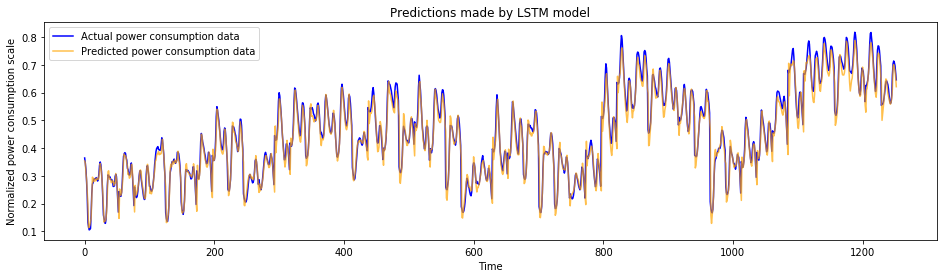

In [42]:
plt.figure(figsize=(16,4))
plt.plot(y_test, color='blue',label='Actual power consumption data')
plt.plot(lstm_predictions, alpha=0.7, color='orange',label='Predicted power consumption data')
plt.title("Predictions made by LSTM model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

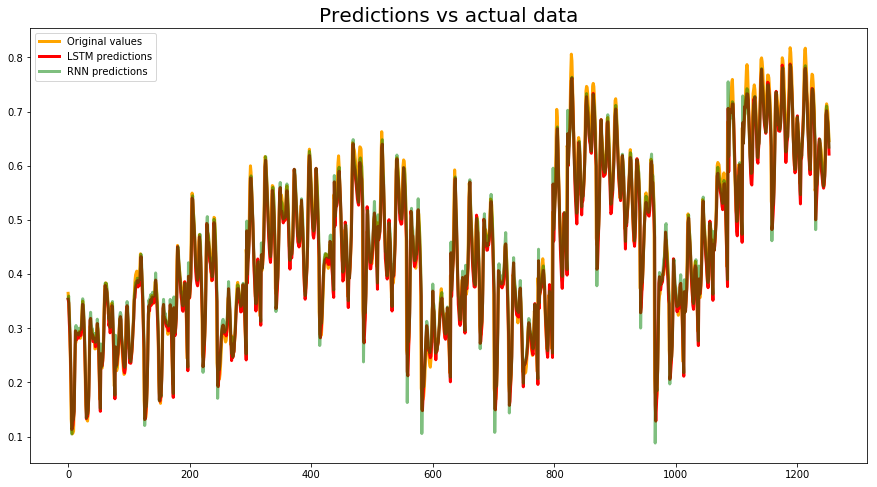

In [43]:
plt.figure(figsize=(15,8))
plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()